In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd drive/MyDrive/phd_projects/rnn/rnn_v1_0_0

[Errno 2] No such file or directory: 'drive/MyDrive/phd_projects/rnn/rnn_v1_0_0'
/content/drive/MyDrive/phd_projects/rnn/rnn_v1_0_0


In [ ]:
# # LSTM
# RNN_MODULE = 'lstm'
# N_CLUSTERS = 25
# HIDDEN_LAYER_SIZE = 64
# NN_MODEL_STATES_DIM_SIZE = HIDDEN_LAYER_SIZE * 2
# DATASET_TYPE = 'speech'

# GRU
RNN_MODULE = 'gru'
N_CLUSTERS = 15
HIDDEN_LAYER_SIZE = 64
NN_MODEL_STATES_DIM_SIZE = HIDDEN_LAYER_SIZE
DATASET_TYPE = 'speech'

# # RNN
# RNN_MODULE = 'rnn'
# N_CLUSTERS = 100
# HIDDEN_LAYER_SIZE = 64
# NN_MODEL_STATES_DIM_SIZE = HIDDEN_LAYER_SIZE
# DATASET_TYPE = 'image'

# Loading Data

In [ ]:
from libs.data_feed import MnistDataSet
import numpy as np

if DATASET_TYPE == 'image':
  x_train, y_train, x_test, y_test = MnistDataSet().get_dataset()
elif DATASET_TYPE == 'speech':
  speech_train_test = np.load(f"cache/speech_train_test.npz")
  x_train = speech_train_test['x_train']
  y_train = speech_train_test['y_train']
  x_test = speech_train_test['x_test']
  y_test = speech_train_test['y_test']
  # raw_x_train=speech_train_test['raw_x_train']
  # raw_x_test=speech_train_test['raw_x_test']
  del speech_train_test
else:
  raise('error in loading dataset')

# Loading Model

In [ ]:
from libs.recurrent_model import RecurrentModel
import tensorflow as tf

rnn_model = RecurrentModel(
  input_shape=(x_train.shape[1],x_train.shape[2]),
  hidden_layer_size=HIDDEN_LAYER_SIZE,
  output_size=y_train.shape[1],
  weights_folder_address=f"{RNN_MODULE}/{DATASET_TYPE}_model_weights",
  rrn_module_name=RNN_MODULE
)
rnn_model.keras_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_input (InputLayer)    [(None, 124, 129)]        0         
                                                                 
 rnn_2 (RNN)                 (None, 64)                37440     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 softmax_2 (Softmax)         (None, 8)                 0         
                                                                 
Total params: 37,960
Trainable params: 37,960
Non-trainable params: 0
_________________________________________________________________


# Extracting Model States

In [ ]:
# states = rnn_model.keras_model_with_states.predict(np.vstack([x_train,x_test]))[0]
# states.shape

In [ ]:
# pred = rnn_model.keras_model.predict(np.vstack([x_train,x_test]))
# pred.shape

In [ ]:
# np.savez_compressed(f"{RNN_MODULE}/{DATASET_TYPE}_model_states/states_pred.npz", states=states, pred=pred)

In [ ]:
saved_model_states_pred = np.load(f"{RNN_MODULE}/{DATASET_TYPE}_model_states/states_pred.npz")
states = saved_model_states_pred['states'][:len(x_train)]
pred =  saved_model_states_pred['pred'][:len(x_train)]
true = y_train

states_test = saved_model_states_pred['states'][len(x_train):]
pred_test =  saved_model_states_pred['pred'][len(x_train):]

true_test = np.argmax(y_test, axis=1)
pred_test = np.argmax(pred_test, axis=1)

del y_test
del y_train
del saved_model_states_pred

In [ ]:
features_mean = states.reshape(-1,NN_MODEL_STATES_DIM_SIZE).mean(axis=0)
features_std = states.reshape(-1,NN_MODEL_STATES_DIM_SIZE).std(axis=0)

states = (states - features_mean)/features_std
states_test = (states_test - features_mean)/features_std

states = states.reshape((-1,x_train.shape[1],NN_MODEL_STATES_DIM_SIZE))
states_test = states_test.reshape((-1,x_train.shape[1],NN_MODEL_STATES_DIM_SIZE))

# States Clustering

In [ ]:
from sklearn.cluster import KMeans
import pickle

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(
    states.reshape(-1,NN_MODEL_STATES_DIM_SIZE)[np.random.choice(states.shape[0]*states.shape[1],x_train.shape[0]),:]
)

with open(f'{RNN_MODULE}/{DATASET_TYPE}_model_kmeans/kmeans_{str(N_CLUSTERS)}.pickle', 'wb') as handle:
  pickle.dump(kmeans, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(f'{RNN_MODULE}/{DATASET_TYPE}_model_kmeans/kmeans_{str(N_CLUSTERS)}.pickle', 'rb') as handle:
  kmeans = pickle.load(handle)

traces = kmeans.predict(states.reshape(-1,NN_MODEL_STATES_DIM_SIZE)).reshape((-1,states.shape[1]))
distances_to_clusters = kmeans.transform(states.reshape(-1,NN_MODEL_STATES_DIM_SIZE)).min(axis=1)

max_distance_in_clusters = distances_to_clusters.max()
mean_distance_in_clusters = distances_to_clusters.mean()

# traces_test = kmeans.predict(states_test.reshape(-1,NN_MODEL_STATES_DIM_SIZE)).reshape((-1,states_test.shape[1]))

# DTMC

In [ ]:
import seaborn as sn
from libs.dtmc import DTMC

dtmc_model = DTMC(traces, None, N_CLUSTERS)
del traces

# DTMC Evaluation

In [ ]:
from libs.dtmc_evaluation import DtmcEvaluator

dtmc_evaluator = DtmcEvaluator()

last_states_true_based_df = dtmc_evaluator.calculate_true_label_based_last_state_df(dtmc_model.traces_df, true)
purity, last_states_count_mean, last_states_df = dtmc_evaluator.calculate_dtmc_purity(dtmc_model.traces_df, pred)

print('N Clusters:', N_CLUSTERS)
print('DTMC purity:', purity)
print('DTMC last states count mean:', last_states_count_mean)
print('Goodness Score:', (purity ** 10) * last_states_count_mean)
print(f'[Last States Count / {true.shape[1]}] Scale: ', len(np.unique(last_states_df['last_state']))/true.shape[1])
print('\nlast_states_true_based_df:\n',last_states_true_based_df[0:5])
print('\nlast_states_df:')
last_states_df[40:60]

N Clusters: 15
DTMC purity: 0.97671875
DTMC last states count mean: 426.6666666666667
Goodness Score: 337.1195698453237
[Last States Count / 8] Scale:  1.875

last_states_true_based_df:
    last_state  true_label  count  group_count      prob
0           0           0      2          754  0.002653
1           0           1      1          754  0.001326
2           0           2      6          754  0.007958
3           0           3      4          754  0.005305
4           0           4      3          754  0.003979

last_states_df:


,last_state,pred_label,count,group_count,prob
40,10,3,3,755,0.003974
41,11,6,69,69,1.000000
42,12,0,12,33,0.363636
43,12,1,3,33,0.090909
44,12,3,3,33,0.090909
45,12,5,12,33,0.363636
46,12,6,3,33,0.090909
47,13,0,6,25,0.240000
48,13,1,1,25,0.040000
49,13,2,2,25,0.080000


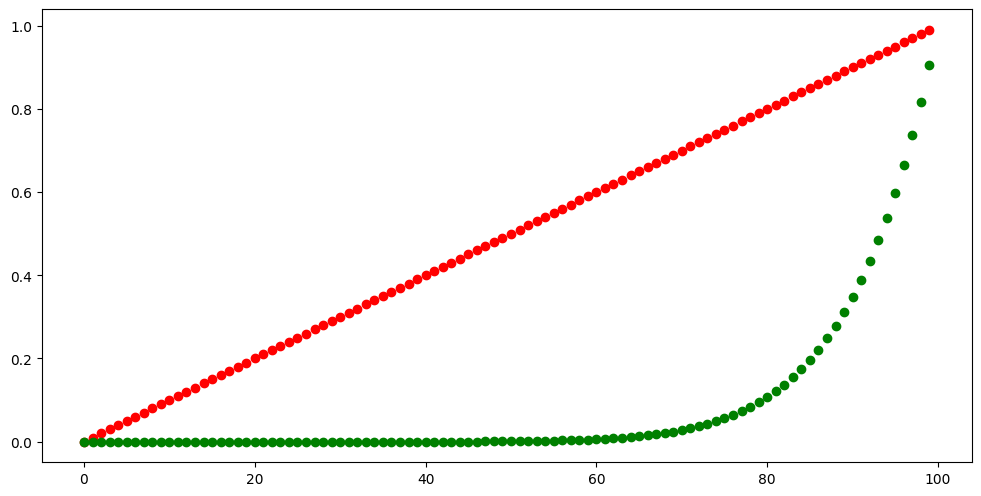

In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
figure(figsize=(12, 6), dpi=100)

plt.scatter(x=np.arange(100),y=(np.arange(100)/100), color = 'red')
plt.scatter(x=np.arange(100),y=(np.arange(100)/100)**10, color = 'green')
plt.show()

# Test Data Transformation

In [ ]:
from libs.image_transformer import ImageTransformer

_image_transformer = ImageTransformer()
x_test_rotated, x_test_zoomed, x_test_zoomed_out = _image_transformer.transform_images(x_test)

In [ ]:
pred_test_rotated = np.argmax(rnn_model.keras_model.predict(x_test_rotated), axis=1)
pred_test_zoomed = np.argmax(rnn_model.keras_model.predict(x_test_zoomed), axis=1)
pred_test_zoomed_out = np.argmax(rnn_model.keras_model.predict(x_test_zoomed_out), axis=1)

50/50 [==============================] - 1s 23ms/step


In [ ]:
def run_the_flow(trans_images):
  trans_states = rnn_model.keras_model_with_states.predict(trans_images)[0]
  trans_traces = kmeans.predict(trans_states.reshape(-1,trans_states.shape[-1])).reshape((-1,trans_states.shape[1]))
  trans_traces_dist_to_centroids = kmeans.transform(trans_states.reshape(-1,trans_states.shape[-1])).min(axis=1).reshape((-1,trans_states.shape[1]))

  return DTMC(trans_traces, trans_traces_dist_to_centroids, N_CLUSTERS)

dtmc_model_test = run_the_flow(x_test)
dtmc_model_test_rotated = run_the_flow(x_test_rotated)
dtmc_model_test_zoomed = run_the_flow(x_test_zoomed)
dtmc_model_test_zoomed_out = run_the_flow(x_test_zoomed_out)

50/50 [==============================] - 1s 24ms/step


# Feature Extraction

In [ ]:
from libs.feature_manager import FeatureExtractor

feature_extractor = FeatureExtractor()

traces_features_df_test = feature_extractor.extract_features(dtmc_model, last_states_df, true_test, dtmc_model_test, pred_test)
traces_features_df_test_rotated = feature_extractor.extract_features(dtmc_model, last_states_df, true_test, dtmc_model_test_rotated, pred_test_rotated)
traces_features_df_test_zoomed = feature_extractor.extract_features(dtmc_model, last_states_df, true_test, dtmc_model_test_zoomed, pred_test_zoomed)
traces_features_df_test_zoomed_out = feature_extractor.extract_features(dtmc_model, last_states_df, true_test, dtmc_model_test_zoomed_out, pred_test_zoomed_out)

# Coverage Criterias Evaluation

In [ ]:
import pandas as pd
import numpy as np

class CoverageCriterias:
  def __init__(
    self,
    dtmc_model,
    last_states_df,
    last_states_true_based_df,
    all_states_counts,
    dataset_classes_count,
    mean_dist_to_centroids,
    max_dist_to_centroids
  ):

    self.last_states_true_based_df = last_states_true_based_df
    self.last_states_df = last_states_df
    self.all_states_counts = all_states_counts
    self.dataset_classes_count = dataset_classes_count
    self.mean_dist_to_centroids = mean_dist_to_centroids
    self.max_dist_to_centroids = max_dist_to_centroids

    self.last_states_in_training = np.unique(self.last_states_df['last_state'].astype(str))
    self.last_states_and_true_label_in_training = (
      self.last_states_true_based_df['last_state'].astype(str)\
      + '.' + self.last_states_true_based_df['true_label'].astype(str)
    ).values

    self.train_states_np, self.train_states_count_np = np.unique(dtmc_model.traces_df, return_counts=True)

    train_traces_df = dtmc_model.traces_df.copy()
    train_transitions_df = train_traces_df.transpose().reset_index(drop=True)[0:-1]\
                                          .reset_index(drop=True).astype(str) + '_' +\
                                          train_traces_df.transpose()\
                                          .reset_index(drop=True)[1:]\
                                          .reset_index(drop=True).astype(str)
    self.train_transitions_np, self.train_transitions_count_np = np.unique(train_transitions_df, return_counts=True)

  def accuracy(self, traces_features_df):
    return 1 - traces_features_df['trace_label_is_wrong'].sum()/len(traces_features_df)

  def accuracy_on_coverage(self, traces_features_df, traces_covering_type_np):
    traces_features_df['traces_covering_type'] = traces_covering_type_np.astype(float)
    traces_features_df['accuracy_weight'] = 1
    agg_df = traces_features_df.query('traces_covering_type>-1')[[
      'traces_covering_type', 'trace_label_is_wrong', 'accuracy_weight'
    ]].groupby('traces_covering_type').sum().reset_index()

    accuracy_on_each_block = 1-(agg_df['trace_label_is_wrong']/agg_df['accuracy_weight'])
    acc = (accuracy_on_each_block * agg_df['accuracy_weight']).sum()/agg_df['accuracy_weight'].sum()
    return acc

  def new_last_state_coverage(self, traces_features_df, traces_df, traces_dist_to_centroids_df, transitions_df):
    seen_last_states_in_this_test = np.unique(traces_df[traces_df.shape[1]-1].values.astype(str))
    coverage_coe = np.logical_not(np.isin(seen_last_states_in_this_test, self.last_states_in_training)).sum() /\
                   (self.all_states_counts - len(self.last_states_in_training))

    traces_covering_type_np = np.logical_not(np.isin(traces_df[traces_df.shape[1]-1].values.astype(str), self.last_states_in_training))
    traces_covering_type_np = traces_df[traces_df.shape[1]-1].values.astype(int) * traces_covering_type_np - 1

    return coverage_coe, traces_covering_type_np

  def all_labels_and_last_states_coverage(self, traces_features_df, traces_df, traces_dist_to_centroids_df, transitions_df):
    seen_last_states_in_this_test = np.unique(
      traces_df[traces_df.shape[1]-1].astype(str) + '.' + traces_features_df['true_label'].astype(str)
    )

    coverage_coe = len(seen_last_states_in_this_test) / (self.all_states_counts * self.dataset_classes_count)
    traces_covering_type_np = (traces_df[traces_df.shape[1]-1].values.astype(float) +
                               traces_features_df['true_label'].apply(lambda x: float('0.'+str(x))).values)

    return coverage_coe, traces_covering_type_np

  def weighted_all_labels_and_last_states_coverage(self, traces_features_df, traces_df, traces_dist_to_centroids_df, transitions_df):
    seen_last_states_in_this_test = np.unique(
      traces_df[traces_df.shape[1]-1].astype(str) + '.' + traces_features_df['true_label'].astype(str)
    )
    weights = 1/(self.last_states_true_based_df['count'])

    mutual_last_states_and_labels = np.isin(self.last_states_and_true_label_in_training,
                                            seen_last_states_in_this_test)
    not_mutual_last_states_and_labels_count = len(seen_last_states_in_this_test) - np.sum(mutual_last_states_and_labels)

    coverage_coe =  ((mutual_last_states_and_labels * weights).sum() + not_mutual_last_states_and_labels_count)/\
                    (weights.sum() + not_mutual_last_states_and_labels_count)

    traces_covering_type_np = (traces_df[traces_df.shape[1]-1].values.astype(float) +
                               traces_features_df['true_label'].apply(lambda x: float('0.'+str(x))).values)

    return coverage_coe, traces_covering_type_np

  def n_step_last_state_boundry_coverage(self, traces_features_df, traces_df, traces_dist_to_centroids_df, transitions_df):
    last_states_dist = traces_dist_to_centroids_df[traces_dist_to_centroids_df.shape[1]-1]
    covered_layers = (last_states_dist/self.mean_dist_to_centroids).astype(str)

    coverage_value = np.unique(
      covered_layers[last_states_dist > self.max_dist_to_centroids] + '.' +\
      traces_df[traces_df.shape[1]-1].values[last_states_dist > self.max_dist_to_centroids].astype(str)
    ).__len__()

    traces_covering_type_np = (covered_layers + '.' +\
                               traces_df[traces_df.shape[1]-1].values.astype(str))
    _, traces_covering_type_np = np.unique(traces_covering_type_np, return_inverse=True)
    traces_covering_type_np[last_states_dist < self.max_dist_to_centroids] = -1

    return coverage_value, traces_covering_type_np


  def basic_last_state_coverage(self, traces_features_df, traces_df, traces_dist_to_centroids_df, transitions_df):
    temp_last_states = np.unique(traces_df[traces_df.shape[1]-1].astype(str))
    coverage_coe = np.isin(temp_last_states, self.last_states_in_training).sum() / len(self.last_states_in_training)

    traces_covering_type_np = traces_df[traces_df.shape[1]-1].values.astype(int)
    traces_covering_type_np[np.logical_not(np.isin(traces_covering_type_np.astype(str), self.last_states_in_training))] = -1

    return coverage_coe, traces_covering_type_np


  def basic_labels_and_last_state_coverage(self, traces_features_df, traces_df, traces_dist_to_centroids_df, transitions_df):
    seen_last_states_and_true_label_in_this_test = np.unique(
      traces_df[traces_df.shape[1]-1].astype(str) + '.' + traces_features_df['true_label'].astype(str)
    )
    coverage_coe = np.isin(seen_last_states_and_true_label_in_this_test, self.last_states_and_true_label_in_training).sum() /\
                  len(self.last_states_and_true_label_in_training)

    traces_covering_type_np = (traces_df[traces_df.shape[1]-1].astype(str) + '.' + traces_features_df['true_label'].astype(str))
    traces_covering_type_np[np.logical_not(np.isin(traces_covering_type_np, self.last_states_and_true_label_in_training))] = '-1'
    traces_covering_type_np = traces_covering_type_np.values.astype(float)

    return coverage_coe, traces_covering_type_np


  def weighted_basic_labels_and_last_state_coverage(self, traces_features_df, traces_df, traces_dist_to_centroids_df, transitions_df):
    seen_last_states_and_true_label_in_this_test = np.unique(
      traces_df[traces_df.shape[1]-1].astype(str) + '.' + traces_features_df['true_label'].astype(str)
    )

    mutual = np.isin(self.last_states_and_true_label_in_training, seen_last_states_and_true_label_in_this_test)
    weights = self.last_states_true_based_df['count'].values

    coverage_coe = (mutual*weights).sum() / (weights).sum()

    traces_covering_type_np = (traces_df[traces_df.shape[1]-1].astype(str) + '.' + traces_features_df['true_label'].astype(str))
    traces_covering_type_np[np.logical_not(np.isin(traces_covering_type_np, self.last_states_and_true_label_in_training))] = '-1'
    traces_covering_type_np = traces_covering_type_np.values.astype(float)

    return coverage_coe, traces_covering_type_np


  def basic_states_coverage(self, traces_features_df, traces_df, traces_dist_to_centroids_df, transitions_df):
    traces_states = np.unique(traces_df)
    coverage_coe = np.isin(traces_states, self.train_states_np).sum() / len(self.train_states_np)

    traces_df['all_seen_states'] = traces_df.apply(lambda x: np.unique(x.values), axis=1)
    traces_df['no_new_state'] = traces_df['all_seen_states'].apply(lambda x: np.logical_not(np.isin(x,self.train_states_np)).sum()==0)
    _, traces_covering_type_np = np.unique(traces_df['all_seen_states'].astype(str).values, return_inverse=True)
    traces_covering_type_np = (traces_covering_type_np + 1) * traces_df['no_new_state'].values - 1

    return coverage_coe, traces_covering_type_np


  def weighted_states_coverage(self, traces_features_df, traces_df, traces_dist_to_centroids_df, transitions_df):
    traces_states = np.unique(traces_df)

    mutual_states = np.isin(self.train_states_np, traces_states)
    weights = 1/(self.train_states_count_np)

    not_mutual_states_count = len(traces_states) - np.sum(mutual_states)

    coverage_coe = (np.sum(mutual_states * weights)+not_mutual_states_count) / (np.sum(weights)+not_mutual_states_count)

    traces_df['all_seen_states'] = traces_df.apply(lambda x: str(np.unique(x.values)), axis=1)
    _, traces_covering_type_np = np.unique(traces_df['all_seen_states'].values, return_inverse=True)
    return coverage_coe, traces_covering_type_np


  def n_step_states_boundry_coverage(self, traces_features_df, traces_df, traces_dist_to_centroids_df, transitions_df):
    max_states_dist = traces_dist_to_centroids_df.max(axis=1).values
    max_states_dist_related_states_index = np.argmax(traces_dist_to_centroids_df.values, axis=1)
    max_states_dist_related_states = np.diag(traces_df.values[:, max_states_dist_related_states_index])
    covered_layers = (max_states_dist/self.mean_dist_to_centroids).astype(str)

    coverage_value = np.unique(
      pd.Series(covered_layers[max_states_dist > self.max_dist_to_centroids]) + '.' +\
      pd.Series(max_states_dist_related_states[max_states_dist > self.max_dist_to_centroids].astype(str))
    ).__len__()

    _, traces_covering_type_np = np.unique(pd.Series(covered_layers) + '.' + pd.Series(max_states_dist_related_states.astype(str)), return_inverse=True)
    traces_covering_type_np[max_states_dist < self.max_dist_to_centroids] = -1

    return coverage_value, traces_covering_type_np


  def basic_trans_coverage(self, traces_features_df, traces_df, traces_dist_to_centroids_df, transitions_df):
    temp_transes = np.unique(transitions_df)
    coverage_coe = np.isin(temp_transes, self.train_transitions_np).sum() / len(self.train_transitions_np)

    transitions_df = transitions_df.transpose()
    transitions_df['all_seen_traces'] = transitions_df.apply(lambda x: np.unique(x.values), axis=1)
    transitions_df['no_new_transition'] = transitions_df['all_seen_traces'].apply(lambda x: np.logical_not(np.isin(x,self.train_transitions_np)).sum()==0)
    _, traces_covering_type_np = np.unique(transitions_df['all_seen_traces'].astype(str).values, return_inverse=True)
    traces_covering_type_np = (traces_covering_type_np + 1) * transitions_df['no_new_transition'].values - 1

    return coverage_coe, traces_covering_type_np

  def weighted_trans_coverage(self, traces_features_df, traces_df, traces_dist_to_centroids_df, transitions_df):
    temp_transes = np.unique(transitions_df)
    mutual_transes = np.isin(self.train_transitions_np, temp_transes)
    not_mutual_transes = np.logical_not(np.isin(temp_transes, self.train_transitions_np))
    weights = 1/(self.train_transitions_count_np)
    coverage_coe = (np.sum(mutual_transes * weights)+np.sum(not_mutual_transes)) / (np.sum(weights)+np.sum(not_mutual_transes))

    transitions_df = transitions_df.transpose()
    transitions_df['all_seen_traces'] = transitions_df.apply(lambda x: str(np.unique(x.values)), axis=1)
    _, traces_covering_type_np = np.unique(transitions_df['all_seen_traces'].values, return_inverse=True)
    return coverage_coe, traces_covering_type_np

<ipython-input-41-80c45af3bd9a>:55: RuntimeWarning: invalid value encountered in long_scalars
  coverage_coe = np.logical_not(np.isin(seen_last_states_in_this_test, self.last_states_in_training)).sum() /\
<ipython-input-41-80c45af3bd9a>:50: RuntimeWarning: invalid value encountered in double_scalars
  acc = (accuracy_on_each_block * agg_df['accuracy_weight']).sum()/agg_df['accuracy_weight'].sum()
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fl

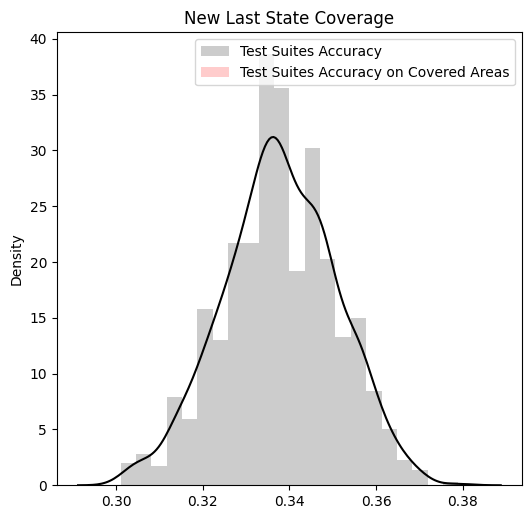

P-value: KstestResult(statistic=1.0, pvalue=2.220446049250313e-15)
----------------------


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


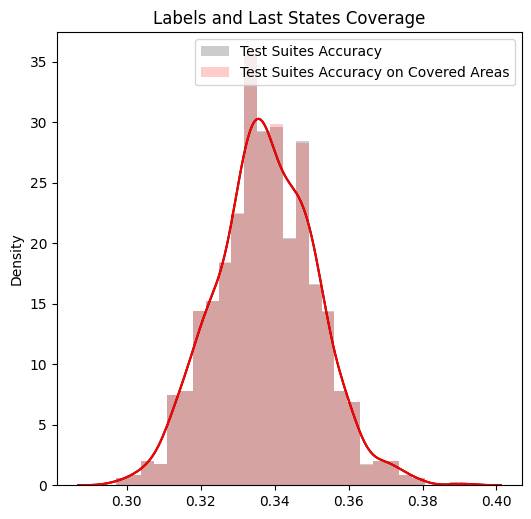

P-value: KstestResult(statistic=0.06733333333333333, pvalue=0.008388187027928873)
----------------------


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


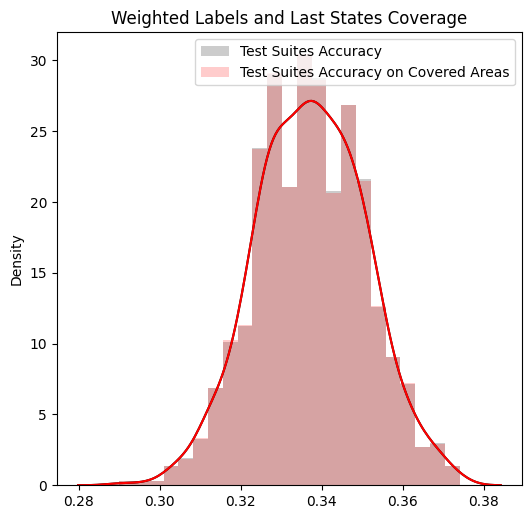

P-value: KstestResult(statistic=0.052, pvalue=0.07605711414805993)
----------------------


<ipython-input-41-80c45af3bd9a>:50: RuntimeWarning: invalid value encountered in double_scalars
  acc = (accuracy_on_each_block * agg_df['accuracy_weight']).sum()/agg_df['accuracy_weight'].sum()
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


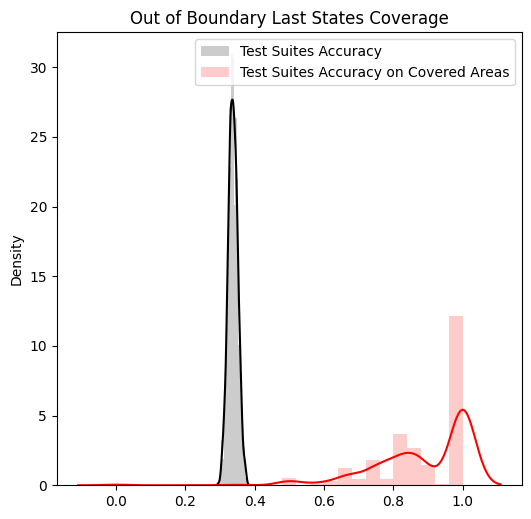

P-value: KstestResult(statistic=0.9986666666666667, pvalue=2.220446049250313e-15)
----------------------


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


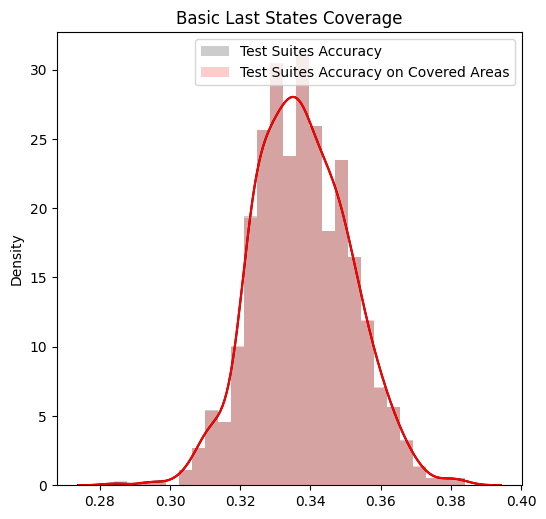

P-value: KstestResult(statistic=0.04566666666666667, pvalue=0.16022220829766154)
----------------------


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


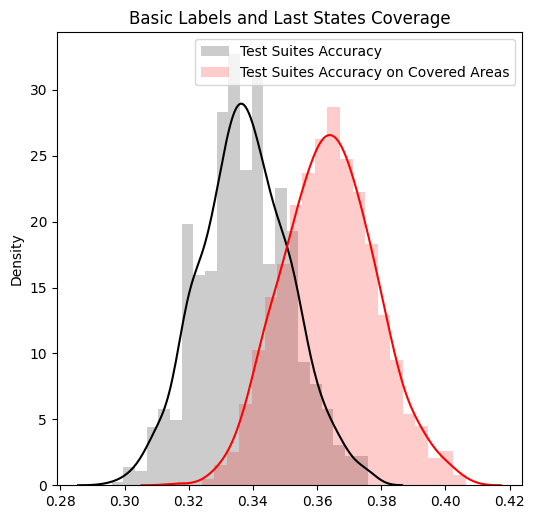

P-value: KstestResult(statistic=0.667, pvalue=2.220446049250313e-15)
----------------------


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


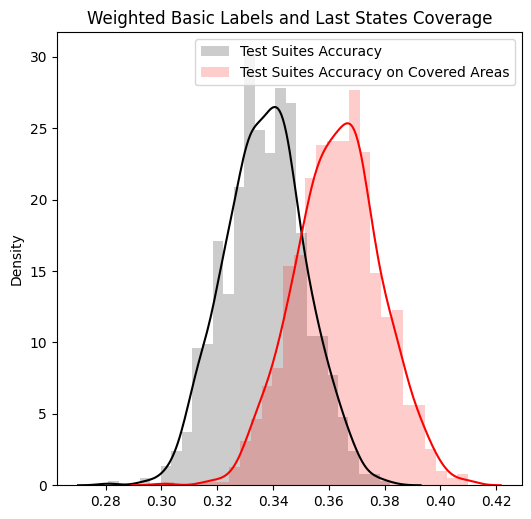

P-value: KstestResult(statistic=0.6536666666666666, pvalue=2.220446049250313e-15)
----------------------


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


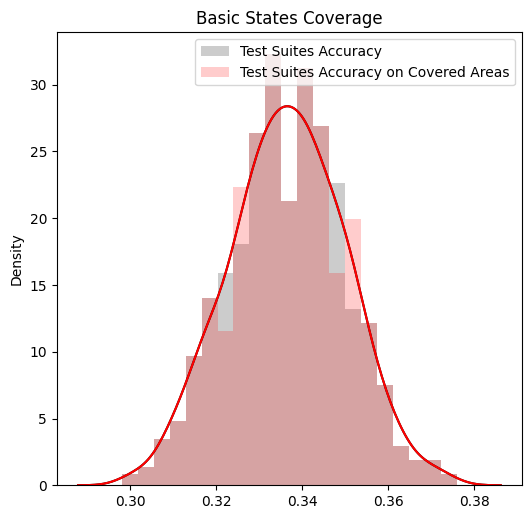

P-value: KstestResult(statistic=0.06466666666666666, pvalue=0.012818960629524923)
----------------------


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


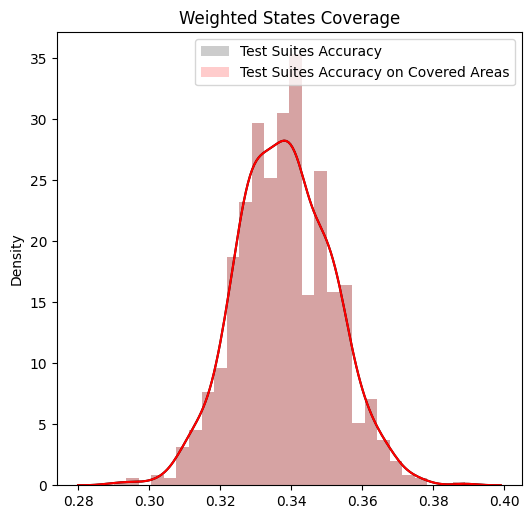

P-value: KstestResult(statistic=0.048666666666666664, pvalue=0.1139506919693778)
----------------------


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


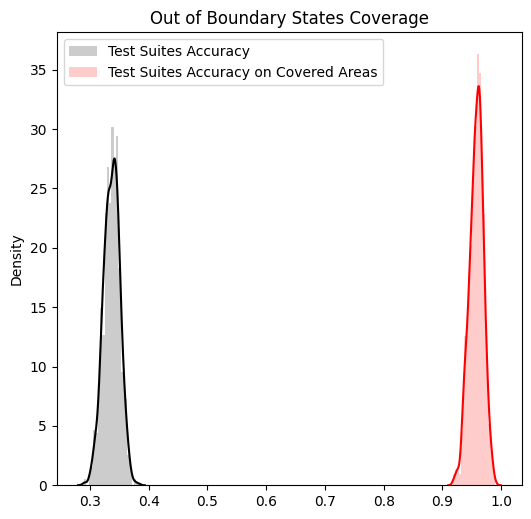

P-value: KstestResult(statistic=1.0, pvalue=2.220446049250313e-15)
----------------------


In [ ]:
# from libs.coverage_criterias import CoverageCriterias
from scipy import stats
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import random

_coverage_criterias = CoverageCriterias(
    dtmc_model,
    last_states_df,
    last_states_true_based_df,
    N_CLUSTERS,
    dataset_classes_count=true.shape[1],
    mean_dist_to_centroids=mean_distance_in_clusters,
    max_dist_to_centroids=max_distance_in_clusters
)

p_values_ls = []

all_traces_features_df_test = traces_features_df_test.append(traces_features_df_test_rotated)\
                                              .append(traces_features_df_test_zoomed)\
                                              .append(traces_features_df_test_zoomed_out)\
                                              .reset_index(drop=True)

all_traces_df_test = dtmc_model_test.traces_df.transpose()\
                                              .append(dtmc_model_test_rotated.traces_df.transpose())\
                                              .append(dtmc_model_test_zoomed.traces_df.transpose())\
                                              .append(dtmc_model_test_zoomed_out.traces_df\
                                              .transpose()).reset_index(drop=True)

all_traces_dist_to_centroids_df_test = dtmc_model_test.traces_df.transpose()\
                                              .append(dtmc_model_test_rotated.traces_dist_to_centroids_df.transpose())\
                                              .append(dtmc_model_test_zoomed.traces_dist_to_centroids_df.transpose())\
                                              .append(dtmc_model_test_zoomed_out.traces_dist_to_centroids_df\
                                              .transpose()).reset_index(drop=True)

tests_transitions_df = all_traces_df_test.transpose().reset_index(drop=True)[0:-1]\
                                          .reset_index(drop=True).astype(str) + '_' +\
                                          all_traces_df_test.transpose()\
                                          .reset_index(drop=True)[1:]\
                                          .reset_index(drop=True).astype(str)
metrics_custom_name = {
    'new_last_state_coverage':'New Last State Coverage',
    'all_labels_and_last_states_coverage':'Labels and Last States Coverage',
    'weighted_all_labels_and_last_states_coverage':'Weighted Labels and Last States Coverage',
    'n_step_last_state_boundry_coverage':'Out of Boundary Last States Coverage',
    'basic_last_state_coverage':'Basic Last States Coverage',
    'basic_labels_and_last_state_coverage':'Basic Labels and Last States Coverage',
    'weighted_basic_labels_and_last_state_coverage':'Weighted Basic Labels and Last States Coverage',
    'basic_states_coverage':'Basic States Coverage',
    'weighted_states_coverage':'Weighted States Coverage',
    'n_step_states_boundry_coverage':'Out of Boundary States Coverage',
    'basic_trans_coverage':'Basic Transitions Coverage',
    'weighted_trans_coverage':'Weighted Transitions Coverage'
}
for metric_function in [
    _coverage_criterias.new_last_state_coverage,
    _coverage_criterias.all_labels_and_last_states_coverage,
    _coverage_criterias.weighted_all_labels_and_last_states_coverage,
    _coverage_criterias.n_step_last_state_boundry_coverage,
    _coverage_criterias.basic_last_state_coverage,
    _coverage_criterias.basic_labels_and_last_state_coverage,
    _coverage_criterias.weighted_basic_labels_and_last_state_coverage,
    _coverage_criterias.basic_states_coverage,
    _coverage_criterias.weighted_states_coverage,
    _coverage_criterias.n_step_states_boundry_coverage,
    # _coverage_criterias.basic_trans_coverage,
    # _coverage_criterias.weighted_trans_coverage
  ]:
  samples_metric_values = []
  samples_accuracy = []
  samples_coverage_accuracy = []
  for i in range(1000):
    random_index = np.random.choice(len(all_traces_features_df_test), 1000, replace=False)
    sample_features_df = all_traces_features_df_test.loc[random_index].copy()
    sample_traces_df = all_traces_df_test.loc[random_index].copy()
    sample_traces_dist_to_centroids_df = all_traces_dist_to_centroids_df_test.loc[random_index].copy()
    sample_transitions_df = tests_transitions_df[random_index].copy()
    coverage_coe, traces_covering_type_np = metric_function(sample_features_df, sample_traces_df, sample_traces_dist_to_centroids_df, sample_transitions_df)
    samples_metric_values.append(coverage_coe)
    samples_accuracy.append(_coverage_criterias.accuracy(sample_features_df))
    samples_coverage_accuracy.append(_coverage_criterias.accuracy_on_coverage(sample_features_df, traces_covering_type_np))

  kstest_result = stats.kstest(
    samples_accuracy, # random.choices(samples_accuracy, k=1000),
    random.choices(
      np.nan_to_num(samples_coverage_accuracy),
      weights=np.nan_to_num(samples_coverage_accuracy),
      k = 1500
    )
  )

  figure(figsize=(6, 6), dpi=100)
  plt.title(metrics_custom_name[str(metric_function).split(' ')[2].split('.')[1]])
  sn.distplot(samples_accuracy, hist_kws={"alpha":0.2}, color='black', label='Test Suites Accuracy', norm_hist=True)
  sn.distplot(np.nan_to_num(samples_coverage_accuracy), hist_kws={"alpha":0.2, "weights":np.nan_to_num(samples_metric_values)},
              color='red', label='Test Suites Accuracy on Covered Areas', norm_hist=True)
  plt.legend()
  plt.show()
  print('P-value:', kstest_result)
  print('----------------------')


del all_traces_df_test
del all_traces_dist_to_centroids_df_test
del tests_transitions_df

# Runtime Trustworthiness

In [ ]:
all_tests_indexes = np.arange(len(all_traces_features_df_test))
np.random.shuffle(all_tests_indexes)
all_traces_features_df_test = all_traces_features_df_test.loc[all_tests_indexes].reset_index(drop=True)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd

split_point = int(len(all_traces_features_df_test) * 0.75)
split_point

# clf = SVC(gamma='auto', max_iter=40000, verbose=True, C=10, kernel='linear')
clf = DecisionTreeClassifier(random_state=0, max_depth=5)
# clf = RandomForestClassifier(max_depth=9, random_state=0, n_estimators=24)

features = ['trace_has_new_transition', 'trace_has_new_state',
       'trace_share_rate_at_last_state', 'trace_count_at_last_state',
       'trace_probability_sum', 'trace_probability_mean', 'trace_probability_prod']

clf = clf.fit(all_traces_features_df_test[features].values[0:split_point],
              all_traces_features_df_test['trace_label_is_wrong'].values[0:split_point]
)
print(all_traces_features_df_test.columns)

features_importance_df = pd.DataFrame()

features_importance_df['feature'] = features
features_importance_df['importance'] = clf.feature_importances_
features_importance_df = features_importance_df.sort_values('importance', ascending = False).reset_index(drop=True)

print(features_importance_df)

Index(['trace_has_new_transition', 'trace_has_new_state',
       'trace_share_rate_at_last_state', 'trace_count_at_last_state',
       'trace_label_is_wrong', 'trace_probability_sum',
       'trace_probability_mean', 'trace_probability_prod', 'pred_label',
       'true_label'],
      dtype='object')
                          feature  importance
0       trace_count_at_last_state    0.862120
1           trace_probability_sum    0.071444
2          trace_probability_mean    0.050877
3  trace_share_rate_at_last_state    0.015559
4        trace_has_new_transition    0.000000
5             trace_has_new_state    0.000000
6          trace_probability_prod    0.000000


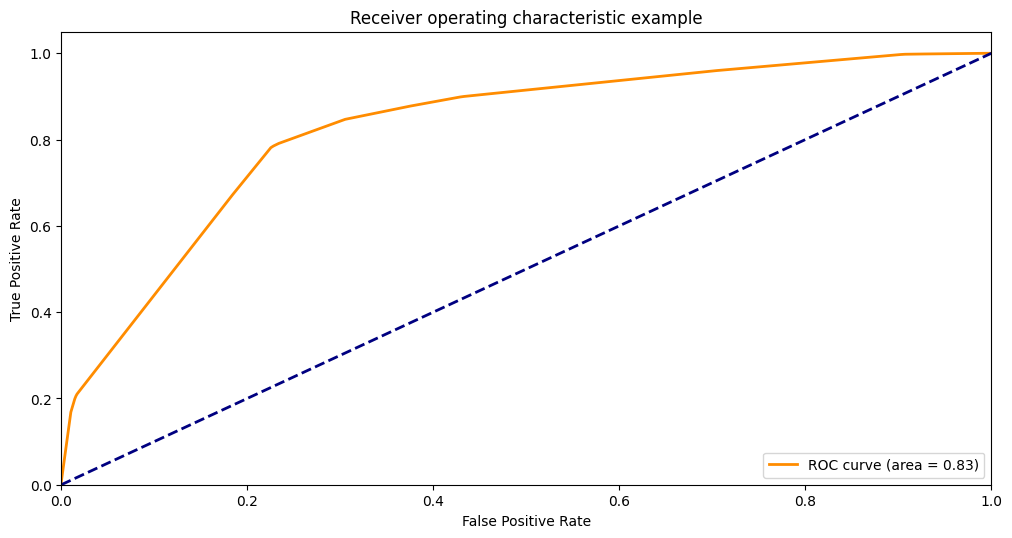

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(all_traces_features_df_test['trace_label_is_wrong'].values[:split_point],
                        clf.predict_proba(all_traces_features_df_test[features].values[:split_point])[:,1])
roc_auc = auc(fpr, tpr)

figure(figsize=(12, 6), dpi=100)

lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()